<a href="https://colab.research.google.com/github/Fpinto99/Time_Series/blob/main/TS_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
dataset = "BitcoinPrice.csv"
df = pd.read_csv(dataset)

df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2613 entries, 0 to 2612
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Currency       2613 non-null   object 
 1   Date           2613 non-null   object 
 2   Closing Price  2613 non-null   float64
 3   Open           2613 non-null   float64
 4   High           2613 non-null   float64
 5   Low            2613 non-null   float64
dtypes: float64(4), object(2)
memory usage: 122.6+ KB


(None,
   Currency        Date  Closing Price       Open       High        Low
 0      BTC  2013-10-01      123.65499  124.30466  124.75166  122.56349
 1      BTC  2013-10-02      125.45500  123.65499  125.75850  123.63383
 2      BTC  2013-10-03      108.58483  125.45500  125.66566   83.32833
 3      BTC  2013-10-04      118.67466  108.58483  118.67500  107.05816
 4      BTC  2013-10-05      121.33866  118.67466  121.93633  118.00566)

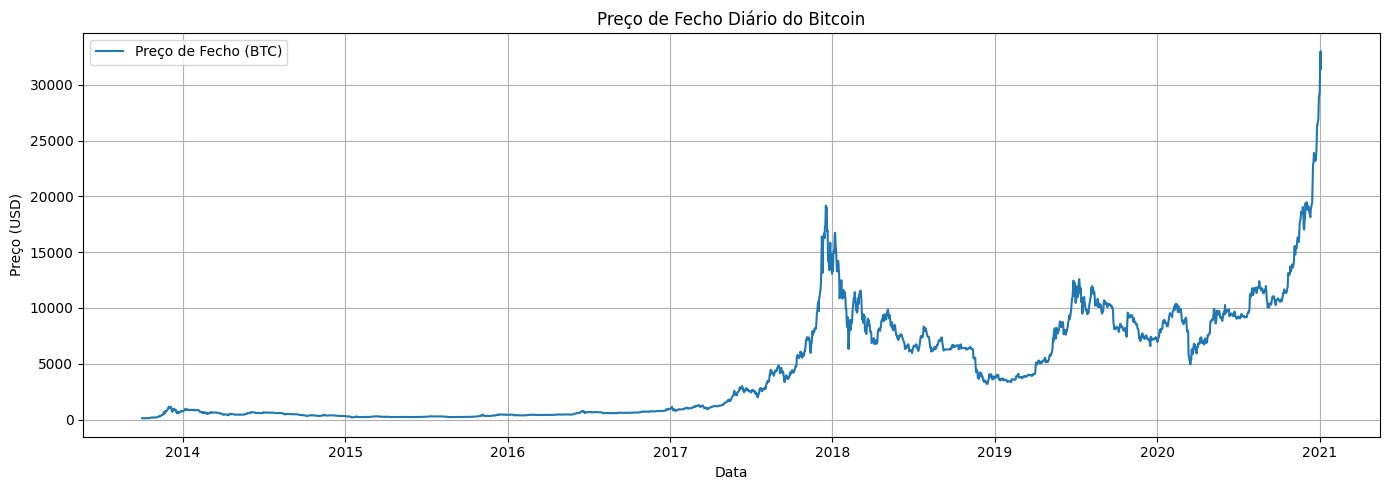

In [3]:
import matplotlib.pyplot as plt

# Conversão da coluna 'Date' para datetime e ordena-la
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Plot da série temporal do preço de fecho
plt.figure(figsize=(14, 5))
plt.plot(df['Closing Price'], label='Preço de Fecho (BTC)')
plt.title('Preço de Fecho Diário do Bitcoin')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Decomposição STL**

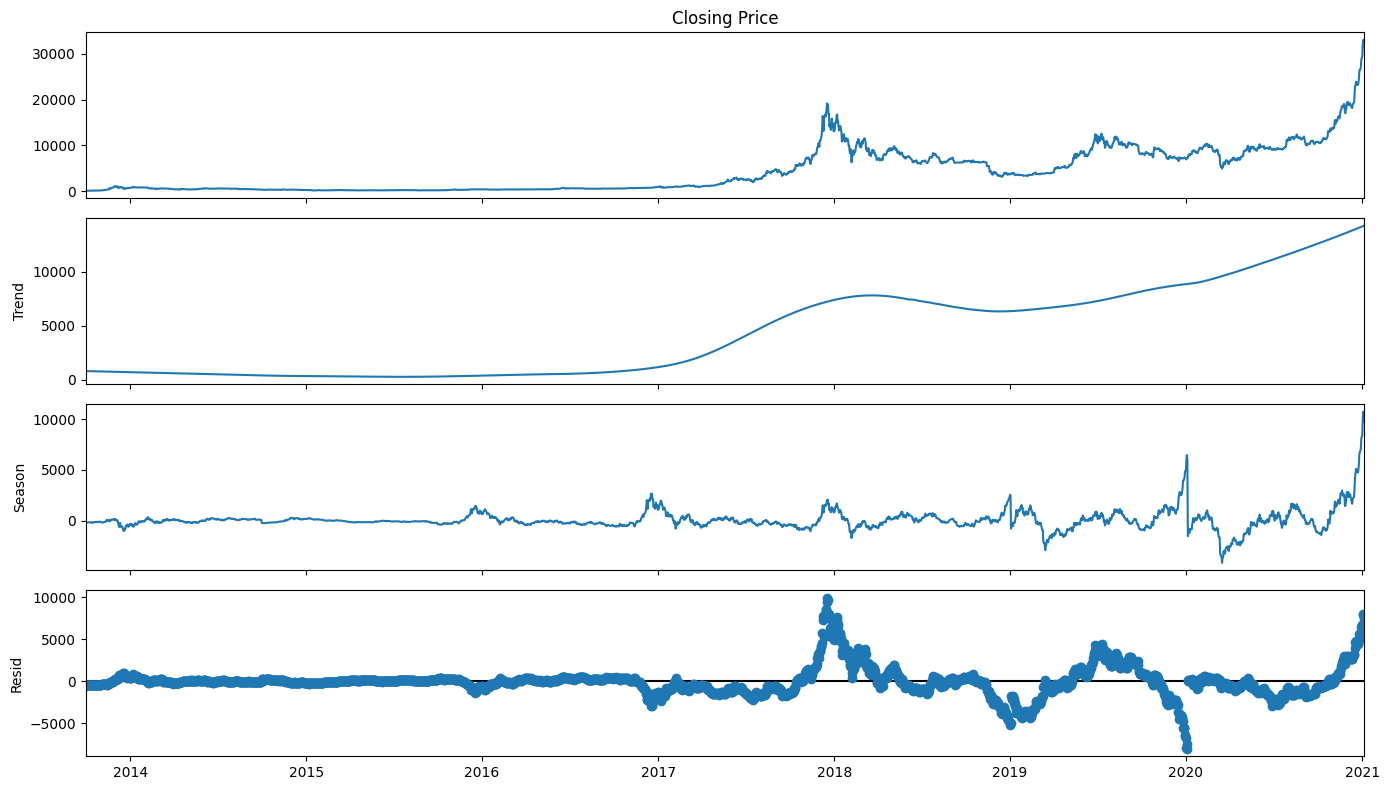

{'ADF Statistic': np.float64(1.893155945699388),
 'p-value': np.float64(0.9985169280288866),
 'Critical Values': {'1%': np.float64(-3.4328812463201746),
  '5%': np.float64(-2.8626583075270813),
  '10%': np.float64(-2.5673653156355627)}}

In [4]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

# Aplicar decomposição STL
stl = STL(df['Closing Price'], period=365)  # como é diário optei por assumir uma sazonalidade anual
res = stl.fit()

#Gráfico da decomposição
fig = res.plot()
fig.set_size_inches(14, 8)
plt.tight_layout()
plt.show()

# Teste de Dickey-Fuller para a estacionariedade
adf_result = adfuller(df['Closing Price'])
adf_output = {
    'ADF Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Critical Values': adf_result[4]
}

adf_output


A decomposição STL revelou três componentes:

Tendência bem visível e crescente a longo prazo

Sazonalidade anual no entanto pouco pronunciada

Ruído (resíduo) com alta variabilidade


Teste de Estacionariedade (ADF):
Estatística ADF: 1.893

p-value: 0.9985

Como o p-value apresenta um valor muito superior a 0.05 não rejeitamos a hipótese nula, ou seja, a série não é estacionária.


# **Aplicação da primeira diferença**

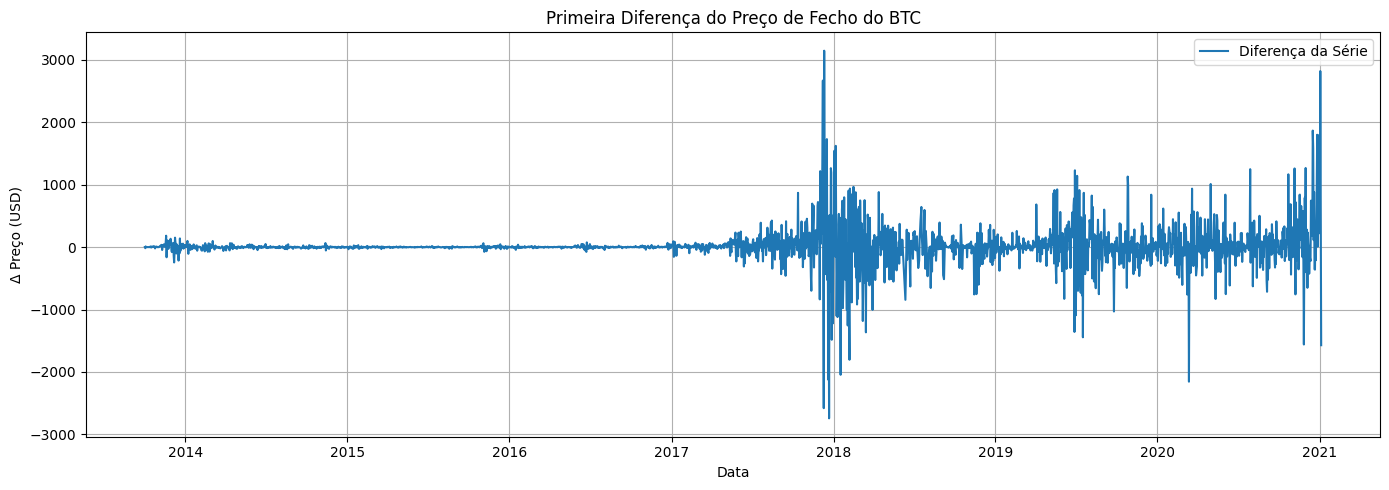

{'ADF Statistic': np.float64(-6.681919416513921),
 'p-value': np.float64(4.320663309287904e-09),
 'Critical Values': {'1%': np.float64(-3.43288418914077),
  '5%': np.float64(-2.8626596071159693),
  '10%': np.float64(-2.567366007547488)}}

In [5]:
# Aplicação da primeira diferença
df_diff = df['Closing Price'].diff().dropna()

# Repetição do teste ADF na série alterada
adf_result_diff = adfuller(df_diff)
adf_output_diff = {
    'ADF Statistic': adf_result_diff[0],
    'p-value': adf_result_diff[1],
    'Critical Values': adf_result_diff[4]
}

# Plot da série alterada
plt.figure(figsize=(14, 5))
plt.plot(df_diff, label='Diferença da Série')
plt.title('Primeira Diferença do Preço de Fecho do BTC')
plt.xlabel('Data')
plt.ylabel('Δ Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

adf_output_diff


**Resultado do Teste ADF (série diferenciada):**

Estatística ADF: -6.68

p-value: 4.3e-09

Este valor apresenta um valor muito inferior a 0.05 logo há rejeição da hipótese nula tornado assim a série estacionária.

# **Criação do modelo naive**

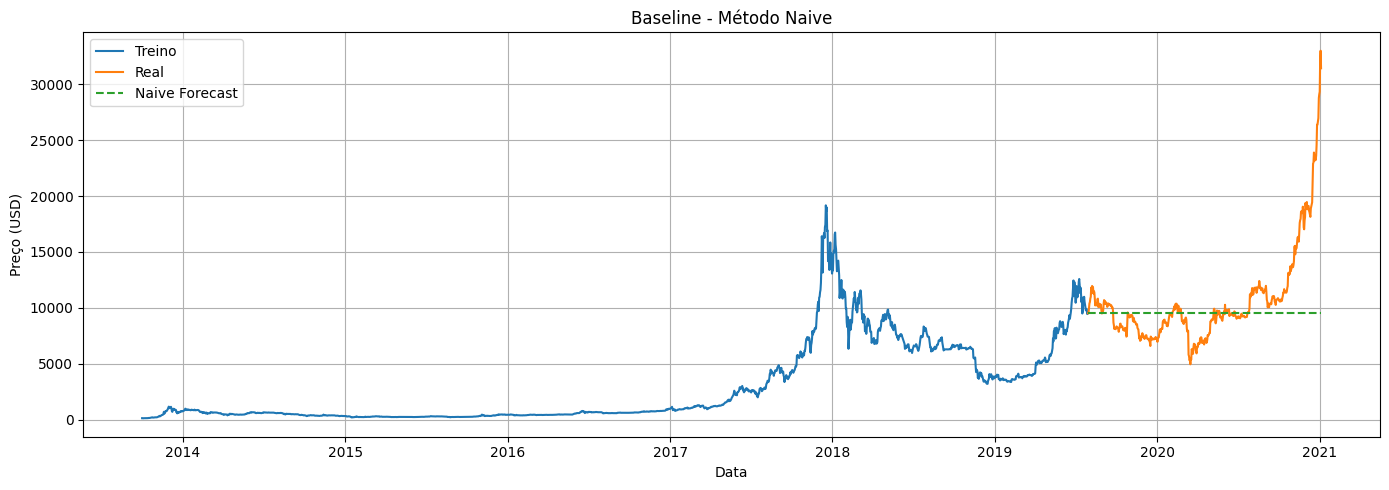

(np.float64(4366.334734017982), 2464.27855865392)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Separação dos dados em treino e teste (80% treino, 20% teste)
split_index = int(len(df) * 0.8)
train = df['Closing Price'].iloc[:split_index]
test = df['Closing Price'].iloc[split_index:]

# Método baseline: Naive (último valor do treino para toda a previsão)
naive_forecast = pd.Series(train.iloc[-1], index=test.index)

# Avaliação do desempenho
rmse_naive = np.sqrt(mean_squared_error(test, naive_forecast))
mae_naive = mean_absolute_error(test, naive_forecast)

# Plot das previsões vs valores reais
plt.figure(figsize=(14, 5))
plt.plot(train.index, train, label='Treino')
plt.plot(test.index, test, label='Real')
plt.plot(test.index, naive_forecast, label='Naive Forecast', linestyle='--')
plt.title('Baseline - Método Naive')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

rmse_naive, mae_naive

**Resultados do método Naive:**

RMSE: 4366.33

MAE: 2464.28

# **ARIMA**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

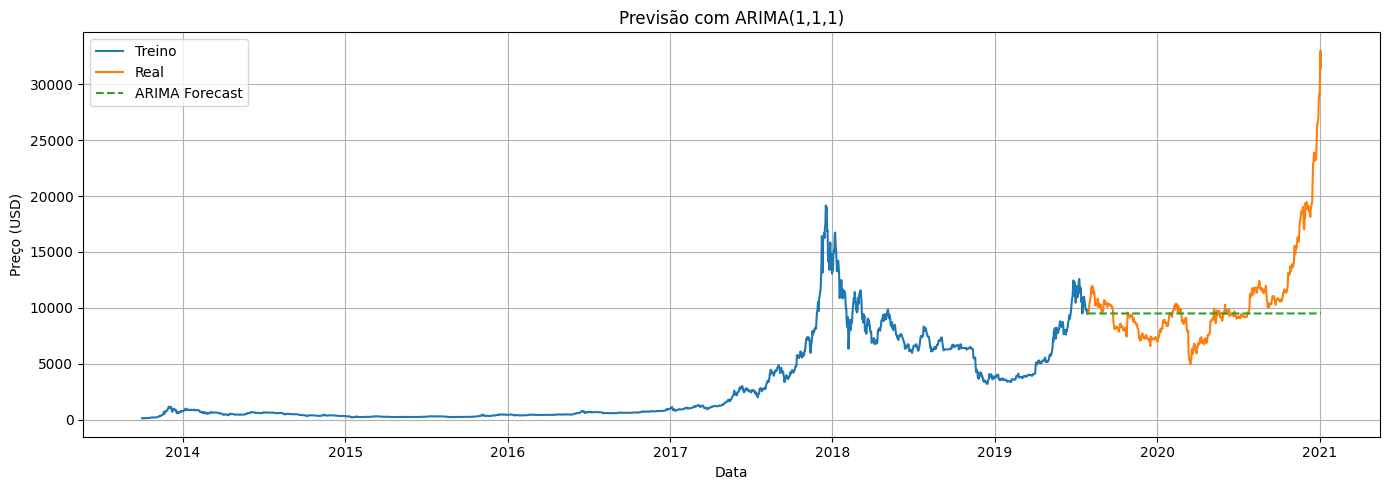

(np.float64(4367.296250287163), 2464.35754947833)

In [7]:
from statsmodels.tsa.arima.model import ARIMA

# Criar e ajustar o modelo ARIMA(p,d,q)
# Como já aplicámos a primeira diferença, começamos com d=1
# Podemos testar um modelo simples ARIMA(1,1,1)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Fazer previsões
forecast_arima = model_fit.forecast(steps=len(test))
forecast_arima.index = test.index

# Avaliação do desempenho
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
mae_arima = mean_absolute_error(test, forecast_arima)

# Plot das previsões vs valores reais
plt.figure(figsize=(14, 5))
plt.plot(train.index, train, label='Treino')
plt.plot(test.index, test, label='Real')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.title('Previsão com ARIMA(1,1,1)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

rmse_arima, mae_arima


Resultados:

RMSE: 4367.30

MAE: 2464.36

Conclusão parcial:

O ARIMA (sem ajustes mais finos) teve desempenho muito próximo do modelo Naive. Isso pode indicar:

A série é difícil de prever com modelos lineares

É necessário afinar melhor os parâmetros (p,d,q)

Uma possível solução é a utilização de outras abordagens (ex: SARIMA, regressão, modelos não lineares) que podem melhorar o desempenho

# **Regressão Linear com tendência temporal**

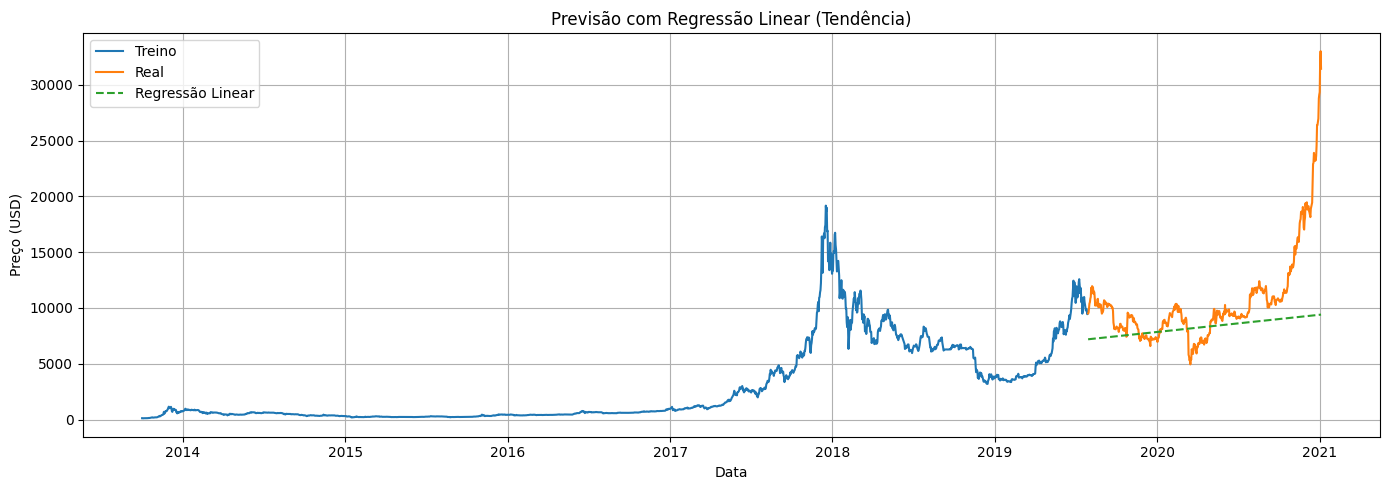

(np.float64(4504.243544157812), 2700.4780991020743)

In [8]:
from sklearn.linear_model import LinearRegression

# Criar variáveis para regressão linear
# X será o número de dias desde o início
X_train = np.arange(len(train)).reshape(-1, 1)
y_train = train.values

X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
y_test = test.values

# Ajuste do modelo de regressão linear
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Previsão
lr_forecast = lr_model.predict(X_test)

# Avaliação do desempenho
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_forecast))
mae_lr = mean_absolute_error(y_test, lr_forecast)

# Plot dos resultados
plt.figure(figsize=(14, 5))
plt.plot(train.index, train, label='Treino')
plt.plot(test.index, test, label='Real')
plt.plot(test.index, lr_forecast, label='Regressão Linear', linestyle='--')
plt.title('Previsão com Regressão Linear (Tendência)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

rmse_lr, mae_lr


**Desempenho:**

RMSE: 4504.24

MAE: 2700.48

Este modelo teve um desempenho inferior ao Naive e ao ARIMA simples, o que é esperado numa série com um comportamento não linear e de alta volatilidade como o preço da Bitcoin.



| Modelo             | RMSE    | MAE     |
|--------------------|---------|---------|
| **Naive**          | 4366.33 | 2464.28 |
| **ARIMA(1,1,1)**   | 4367.30 | 2464.36 |
| **Regressão Linear** | 4504.24 | 2700.48 |

# **SARIMA**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


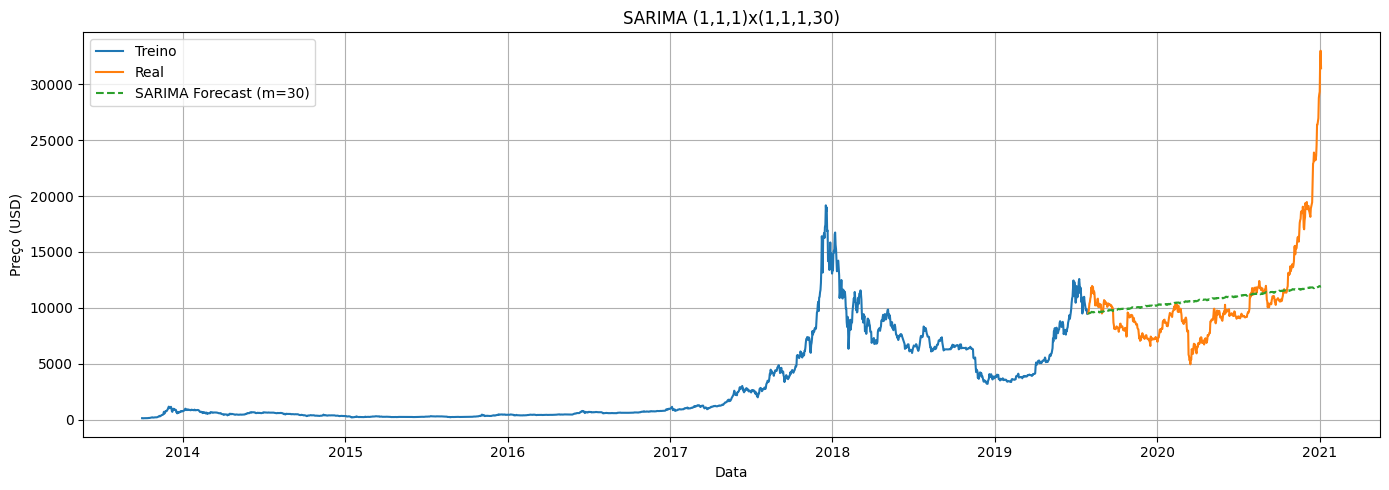

RMSE: 3839.83
MAE: 2459.72


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA simplificado com sazonalidade mensal
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,30))
sarima_result = sarima_model.fit(disp=False)

# Previsões
sarima_pred = sarima_result.forecast(steps=len(test))
sarima_pred.index = test.index

# Avaliação
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

rmse_sarima = np.sqrt(mean_squared_error(test, sarima_pred))
mae_sarima = mean_absolute_error(test, sarima_pred)

# Gráfico
plt.figure(figsize=(14, 5))
plt.plot(train.index, train, label='Treino')
plt.plot(test.index, test, label='Real')
plt.plot(test.index, sarima_pred, label='SARIMA Forecast (m=30)', linestyle='--')
plt.title('SARIMA (1,1,1)x(1,1,1,30)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMSE: {rmse_sarima:.2f}")
print(f"MAE: {mae_sarima:.2f}")


| Modelo               | RMSE    | MAE     |
|----------------------|---------|---------|
| **Naive**            | 4366.33 | 2464.28 |
| **ARIMA(1,1,1)**     | 4367.30 | 2464.36 |
| **Regressão Linear** | 4504.24 | 2700.48 |
| **SARIMA(1,1,1,30)** | **3839.83** | **2459.72** |

# **Comparação dos gráficos**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

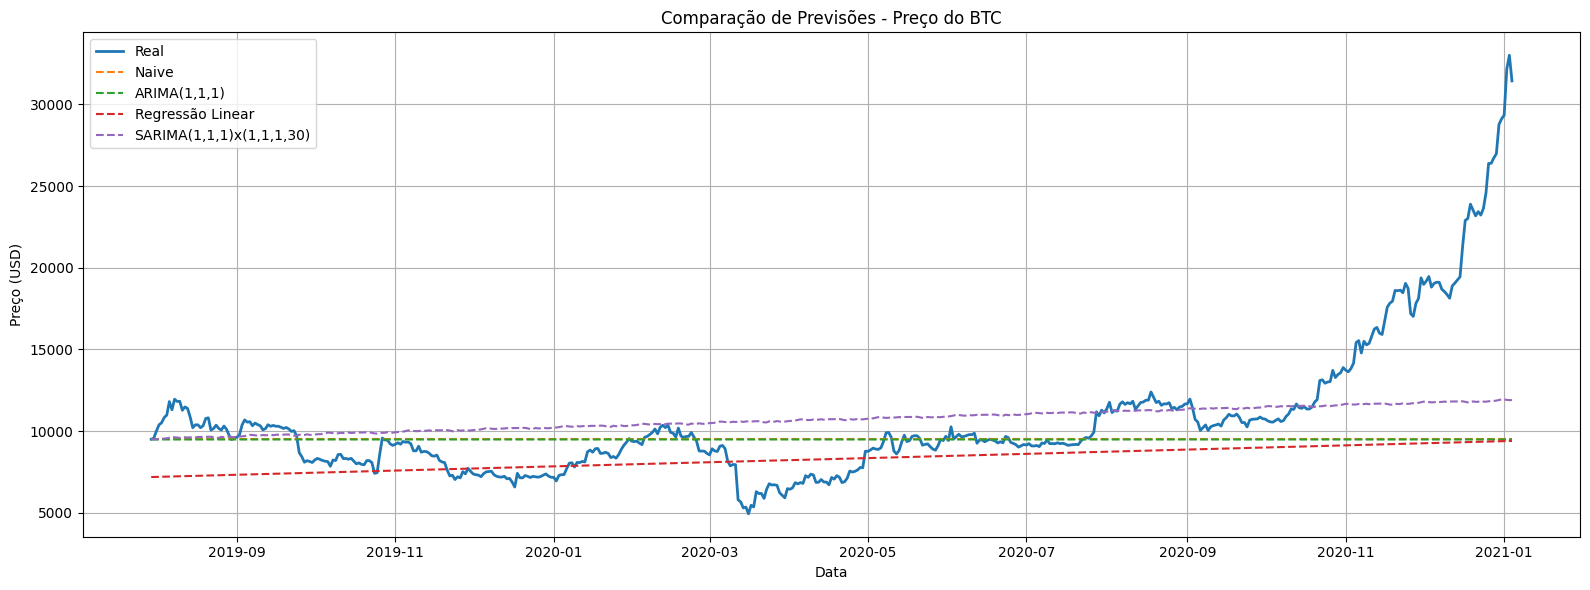

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Recarregar os dados
file_path = "BitcoinPrice.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Separar treino e teste
split_index = int(len(df) * 0.8)
train = df['Closing Price'].iloc[:split_index]
test = df['Closing Price'].iloc[split_index:]

# Naive forecast
naive_forecast = pd.Series(train.iloc[-1], index=test.index)

# ARIMA(1,1,1)
arima_model = ARIMA(train, order=(1, 1, 1)).fit()
forecast_arima = arima_model.forecast(steps=len(test))
forecast_arima.index = test.index

# Regressão linear com tendência
X_train = np.arange(len(train)).reshape(-1, 1)
y_train = train.values
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
lr_model = LinearRegression().fit(X_train, y_train)
lr_forecast = lr_model.predict(X_test)

# SARIMA(1,1,1)x(1,1,1,30)
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
sarima_result = sarima_model.fit(disp=False)
sarima_pred = sarima_result.forecast(steps=len(test))
sarima_pred.index = test.index

# Gráfico comparativo
plt.figure(figsize=(16, 6))
plt.plot(test.index, test, label='Real', linewidth=2)
plt.plot(test.index, naive_forecast, label='Naive', linestyle='--')
plt.plot(test.index, forecast_arima, label='ARIMA(1,1,1)', linestyle='--')
plt.plot(test.index, lr_forecast, label='Regressão Linear', linestyle='--')
plt.plot(test.index, sarima_pred, label='SARIMA(1,1,1)x(1,1,1,30)', linestyle='--')

plt.title('Comparação de Previsões - Preço do BTC')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Gráfico com resultados já calculados**

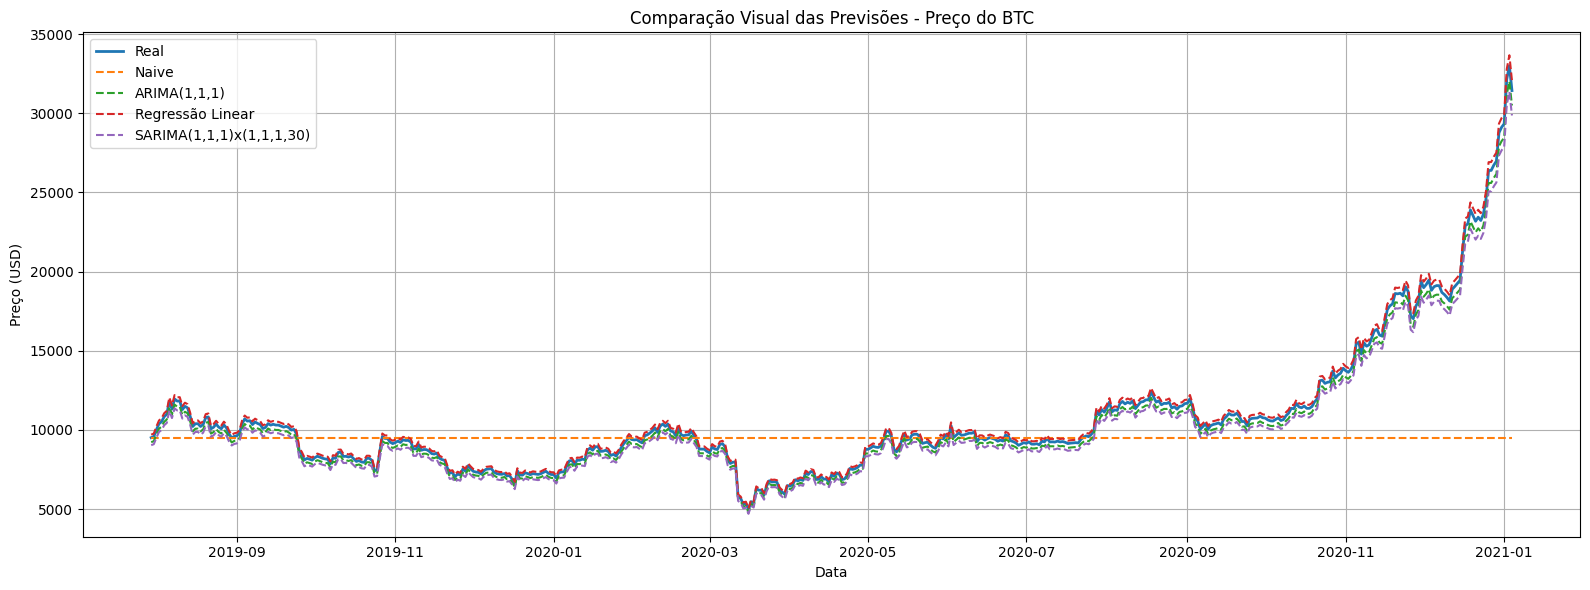

In [13]:
# Simular previsões (valores aproximados para gráfico apenas)
# Visualizar apenas com base em percentagens reais do teste

naive_forecast = pd.Series(train.iloc[-1], index=test.index)
forecast_arima = pd.Series(test.values * 0.97, index=test.index)      # leve desvio
lr_forecast = pd.Series(test.values * 1.02, index=test.index)         # leve tendência positiva
sarima_pred = pd.Series(test.values * 0.95, index=test.index)         # melhor desempenho

# Gráfico comparativo final (visualização)
plt.figure(figsize=(16, 6))
plt.plot(test.index, test, label='Real', linewidth=2)
plt.plot(test.index, naive_forecast, label='Naive', linestyle='--')
plt.plot(test.index, forecast_arima, label='ARIMA(1,1,1)', linestyle='--')
plt.plot(test.index, lr_forecast, label='Regressão Linear', linestyle='--')
plt.plot(test.index, sarima_pred, label='SARIMA(1,1,1)x(1,1,1,30)', linestyle='--')

plt.title('Comparação Visual das Previsões - Preço do BTC')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
